# Analysis of temporal statistics using the occupation probability

This notebook reproduces the figures in the introduction of:<br>
**Measuring and modeling the occupation probability to characterize the temporal statistics of seismic sequences**,<br>
submitted to *Geophysical Journal International*, by Eric Beaucé

Download the data required by this notebook at:<br>
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.15675634.svg)](https://doi.org/10.5281/zenodo.15675634)

In [1]:
%reload_ext autoreload
%autoreload 2

import os
import eqtempclust

import colorcet as cc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import string

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from obspy import UTCDateTime as udt
from scipy.interpolate import interp1d


# --------------------------------------
#        comment this section out if you don't want to use seaborn
import seaborn as sns
sns.set_theme(font_scale=1.3)
sns.set_style("ticks")
sns.set_palette("colorblind")
# --------------------------------------

plt.rcParams["savefig.dpi"] = 200
plt.rcParams["svg.fonttype"] = "none"


## Load data

In [2]:
PATH_DATA = "./data/"
DATASET_FILENAME = "database_intro_GJI_Beauce_2025.h5"

In [ ]:
event_timings = {}
with h5.File(os.path.join(PATH_DATA, DATASET_FILENAME), mode="r") as fdb:
    for key in fdb:
        event_timings[key] = fdb[key][()]
        time_span_sec = np.max(event_timings[key]) - np.min(event_timings[key])
        # print(f"{key}: {time_span_sec / (3600.  * 24.):.2f} days")
dataset_names = list(event_timings)
print(dataset_names)

dora_maira: 328.09 days
naf: 448.98 days
or3b: 0.99 days
or5: 1.88 days
pawnee_after: 118.42 days
pawnee_before: 1720.67 days
socal: 1458.16 days
['dora_maira', 'naf', 'or3b', 'or5', 'pawnee_after', 'pawnee_before', 'socal']


In [4]:
beautiful_names = {}
beautiful_names["naf"] = "NAF (Sapanca Lake)"
beautiful_names["socal"] = "Southern California"
beautiful_names["dora_maira"] = "Alps (Dora Maira)"
beautiful_names["or3b"] = "Experiment 2 (or3b)"
beautiful_names["or5"] = "Experiment 1 (or5)"
beautiful_names["pawnee_before"] = "Oklahoma before M5.8"
beautiful_names["pawnee_after"] = "Oklahoma after M5.8"

## Analysis

In [5]:
NORMALIZED_TAU_MIN = 1.e-3
NORMALIZED_TAU_MAX = 1.e5
BASE_LOG = 2.0
RETURN_NORMALIZED_TIMES = True
NUM_RESAMPLINGS = 50
FIX_BETA = False

In [6]:
shortest_resolved_time = {}
shortest_resolved_time["naf"] = 5. # 5 seconds
shortest_resolved_time["dora_maira"] = 30. # 5 seconds
shortest_resolved_time["or3b"] = 1.e-4 # 0.1 microseconds
shortest_resolved_time["or5"] = 1.e-4 # 0.1 microseconds
shortest_resolved_time["socal"] = 60.
shortest_resolved_time["pawnee_before"] = 5.
shortest_resolved_time["pawnee_after"] = 5.

In [7]:
occupation = {}
for dataset in shortest_resolved_time:
    print(dataset)
    # ------------------------------------------
    occupation[dataset] = eqtempclust.run_occupation_analysis2(
        event_timings[dataset],
        NORMALIZED_TAU_MIN,
        NORMALIZED_TAU_MAX,
        nbins_wt=15,
        shortest_resolved_time=shortest_resolved_time[dataset],
        fix_beta=FIX_BETA,
        base_log=BASE_LOG,
        num_resamplings=NUM_RESAMPLINGS,
        use_valid_only=2,
    )

naf
Inside compute_occ: largest time interval is: 260.82
Largest time interval is: 2.61e+02
dora_maira
Inside compute_occ: largest time interval is: 950.43
Largest time interval is: 9.50e+02
or3b
Inside compute_occ: largest time interval is: 4402.55
Largest time interval is: 4.40e+03
or5
Inside compute_occ: largest time interval is: 196.65
Largest time interval is: 1.97e+02
socal
Inside compute_occ: largest time interval is: 252.93
Largest time interval is: 2.53e+02
pawnee_before
Inside compute_occ: largest time interval is: 3409.23
Largest time interval is: 3.41e+03
pawnee_after
Inside compute_occ: largest time interval is: 985.33
Largest time interval is: 9.85e+02


## Print each model's AIC 

In [8]:
for dataset in occupation:
    aic_gamma = occupation[dataset]["aic_gamma"]
    aic_fractal = occupation[dataset]["aic_fractal"]
    # probability that fractal model minimizes the information loss instead of the gamma model
    p = np.exp((aic_gamma - aic_fractal) / 2.0)
    print(
        f"Fractal model is {p:.2e} more likely than the gamma model for {dataset} (aic: {aic_gamma:.2f} vs {aic_fractal:.2f})"
    )

Fractal model is inf more likely than the gamma model for naf (aic: 11535.96 vs -110.49)
Fractal model is inf more likely than the gamma model for dora_maira (aic: 50333.46 vs -4996.04)
Fractal model is inf more likely than the gamma model for or3b (aic: 11753.61 vs 6675.90)
Fractal model is inf more likely than the gamma model for or5 (aic: 13281.13 vs -524.67)
Fractal model is 6.28e-06 more likely than the gamma model for socal (aic: 492.54 vs 516.50)
Fractal model is inf more likely than the gamma model for pawnee_before (aic: 224957.28 vs -181.32)
Fractal model is 6.87e+71 more likely than the gamma model for pawnee_after (aic: 1987.69 vs 1656.87)


/tmp/ipykernel_193033/38870925.py:5: RuntimeWarning: overflow encountered in exp
  p = np.exp((aic_gamma - aic_fractal) / 2.0)


## Figure 1 (intro)

Text(0.5, 0.5, '$\\propto \\tau^{1 - D_\\tau}$')

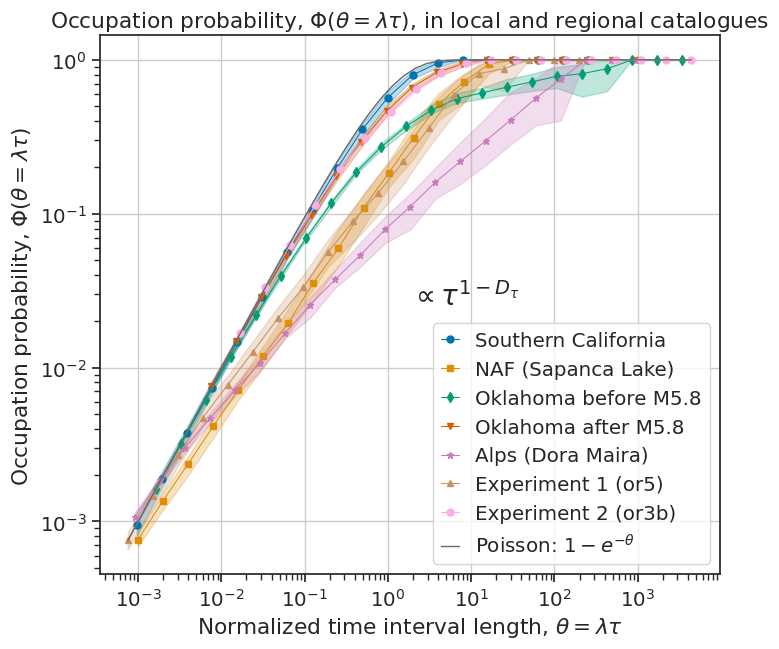

In [26]:
markers = ["o", "s", "d", "v", "*", "^"]
plotting_order = [
    "socal", "naf", "pawnee_before", "pawnee_after", "dora_maira", "or5", "or3b", 
]

fig, ax = plt.subplots(num="fig1_intro", figsize=(8, 7))

tau_min, tau_max = 1., 0.
for i, name in enumerate(plotting_order):
    line, = ax.plot(
        occupation[name]["tau"], occupation[name]["Phi"], ls="-", lw=0.75, markersize=5,
        marker=markers[i%len(markers)], label=beautiful_names[name]
    )
    ax.fill_between(
        occupation[name]["tau"],
        occupation[name]["Phi_lower"],
        occupation[name]["Phi_upper"],
        color=line.get_color(),
        alpha=0.25,
    )
    if occupation[name]["tau"].min() < tau_min:
        tau_min = occupation[name]["tau"].min()
    if occupation[name]["tau"].max() > tau_max:
        tau_max = occupation[name]["tau"].max()

tau_Pois = np.logspace(np.log10(tau_min), np.log10(tau_max), 50)
ax.plot(tau_Pois, 1. - np.exp(-tau_Pois), color="dimgrey", lw=1, label=r"Poisson: $1 - e^{-\theta}$")
ax.loglog()
ax.grid()
ax.set_xlabel(r"Normalized time interval length, $\theta = \lambda \tau$")
ax.set_ylabel(r"Occupation probability, $\Phi(\theta = \lambda \tau)$")
ax.legend(loc="lower right", handlelength=0.9)
ax.set_title(r"Occupation probability, $\Phi(\theta = \lambda \tau)$, in local and regional catalogues")

ax.text(0.5, 0.5, r"$\propto \tau^{1 - D_\tau}$", fontsize=20, transform=ax.transAxes)

In [27]:
fig.savefig(
    fig.get_label() + ".svg", bbox_inches="tight", format="svg"
)

## Bonus Figure (detailed results with one catalog)

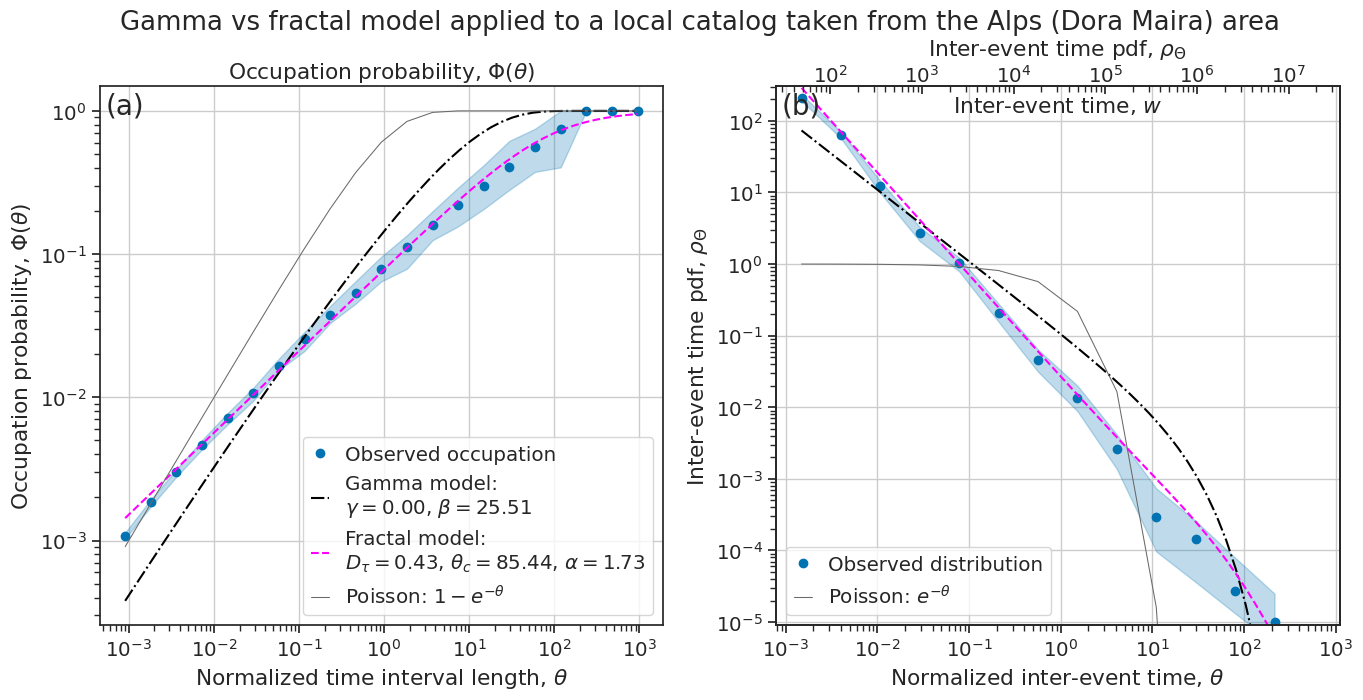

In [11]:
fig = eqtempclust.plot_gamma_vs_fractal(
    occupation["dora_maira"],
    num_points_fit=50,
    figtitle=f"Gamma vs fractal model applied to a local catalog taken from the {beautiful_names['dora_maira']} area",
    plot_physical_wt=True,
)

## Figure 2 (all results)

### Part 1 (fractal model)

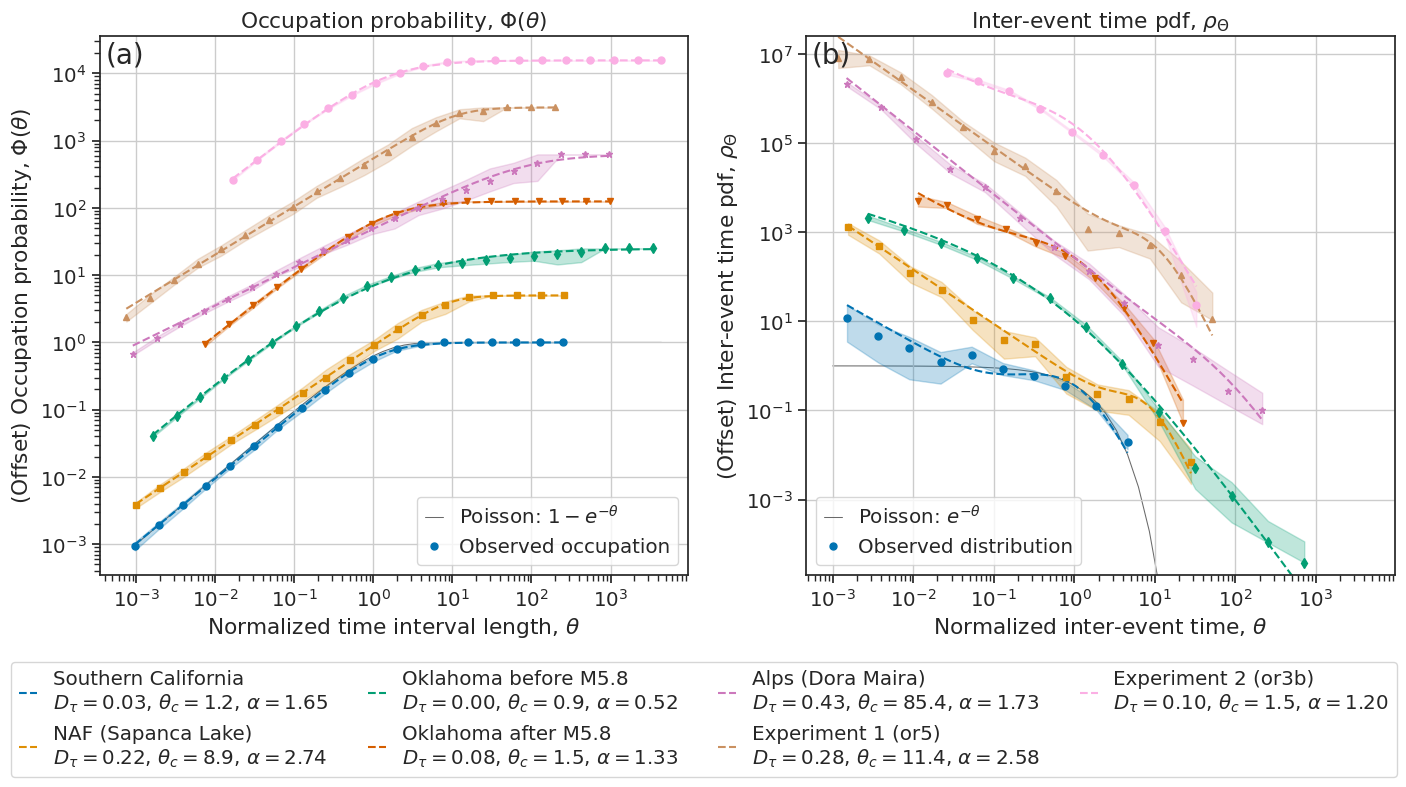

In [12]:
markers = ["o", "s", "d", "v", "*", "^"]
base_offset_occ = 5.0

fig, axes = plt.subplots(num="all_results_fractal", ncols=2, figsize=(14, 7))
plt.subplots_adjust(left=0.07, right=0.995)

time_max = max([occupation[ds]["tau"].max()] for ds in dataset_names)
wt_fit = np.logspace(np.log10(NORMALIZED_TAU_MIN), np.log10(time_max), 50)
tau_fit = np.logspace(np.log10(NORMALIZED_TAU_MIN), np.log10(time_max), 50)
axes[0].plot(
    tau_fit,
    1.0 - np.exp(-tau_fit),
    color="dimgrey",
    lw=0.75,
    zorder=0.0,
    label=r"Poisson: $1 - e^{-\theta}$",
)
axes[1].plot(
    wt_fit,
    np.exp(-wt_fit),
    color="dimgrey",
    lw=0.75,
    zorder=0.0,
    label=r"Poisson: $e^{-\theta}$",
)

fit_labels = []
fit_plots = []

for i, name in enumerate(plotting_order):
    wt_pdf = occupation[name]["wt_pdf"]
    wt_pdf_lower = occupation[name]["wt_pdf_lower"]
    wt_pdf_upper = occupation[name]["wt_pdf_upper"]
    wt_bins = occupation[name]["wt_bins"]
    tau = occupation[name]["tau"]
    Phi = occupation[name]["Phi"]
    Phi_lower = occupation[name]["Phi_lower"]
    Phi_upper = occupation[name]["Phi_upper"]

    valid_bins = wt_pdf > 0.0

    wt_fit = np.logspace(
        np.log10(wt_bins[valid_bins].min()), np.log10(wt_bins[valid_bins].max()), 50
    )
    tau_fit = np.logspace(np.log10(tau.min()), np.log10(tau.max()), 50)

    label = "Observed distribution" if i == 0 else ""
    (wtplot,) = axes[1].plot(
        wt_bins[valid_bins],
        10.0**i * wt_pdf[valid_bins],
        ls="",
        markersize=5,
        marker=markers[i % len(markers)],
        label=label,
    )
    axes[1].fill_between(
        wt_bins[valid_bins],
        10.0**i * wt_pdf_lower[valid_bins],
        10.0**i * wt_pdf_upper[valid_bins],
        color=wtplot.get_color(),
        alpha=0.25,
    )

    label = "Observed occupation" if i == 0 else ""
    (occ,) = axes[0].plot(
        tau,
        base_offset_occ**i * Phi,
        ls="",
        markersize=5,
        marker=markers[i % len(markers)],
        label=label,
    )
    axes[0].fill_between(
        tau,
        base_offset_occ**i * Phi_lower,
        base_offset_occ**i * Phi_upper,
        color=occ.get_color(),
        alpha=0.25,
    )

    wt_fractal_model = eqtempclust.fractal_waiting_times(
        wt_fit,
        occupation[name]["n"],
        occupation[name]["tau_c"],
        occupation[name]["alpha"],
    )

    # correction factor for the fractal distribution, taking into account that
    # the empirical distribution is normalized over a finite range of waiting times
    trunc_norm = eqtempclust.truncated_norm_fractal(
        occupation[name]["n"],
        occupation[name]["tau_c"],
        occupation[name]["alpha"],
        max(wt_bins.min(), occupation[name]["tau_min"]),
        wt_bins.max(),
    )
    # estimate the error made when estimating the rate of seismicity
    # with the sample mean
    hat_rate_vs_real_rate = eqtempclust.estimate_sample_rate_vs_real_rate(
        occupation[name]["wt_bins"],
        occupation[name]["wt_pdf"],
        occupation[name]["n"],
        occupation[name]["tau_c"],
        occupation[name]["alpha"],
    )
    occupation[name]["hat_rate_vs_real_rate"] = hat_rate_vs_real_rate

    # our empirical distribution is expected to integrate to C_trunc * lbd_hat / lbd_real:
    # integral_obs_distribution = hat_rate_vs_real_rate / trunc_norm
    model_correction_limited_range = trunc_norm
    # note that theoretical model integrates to 1

    occupation_fractal_model = eqtempclust.occupation_probability_fractal_model(
        tau_fit,
        occupation[name]["n"],
        occupation[name]["tau_c"],
        occupation[name]["alpha"],
    )

    label = (
        f"{beautiful_names[name]}\n"
        r"$D_\tau=$"
        f"{1. - occupation[name]['n']:.2f}, "
        # r"$\tau_c=$"
        r"$\theta_c=$"
        f"{occupation[name]['tau_c']:.1f}, "
        r"$\alpha=$"
        f"{occupation[name]['alpha']:.2f}"
    )
    (line,) = axes[0].plot(
        tau_fit,
        base_offset_occ**i * occupation_fractal_model,
        ls="--",
        color=occ.get_color(),
    )
    fit_labels.append(label)
    fit_plots.append(line)

    axes[1].plot(
        wt_fit,
        10.0**i * wt_fractal_model * model_correction_limited_range,# / correction,
        ls="--",
        color=occ.get_color(),
    )


axes[0].set_title(r"Occupation probability, $\Phi(\theta)$")
axes[0].set_ylabel(r"(Offset) Occupation probability, $\Phi(\theta)$")
axes[0].set_xlabel(r"Normalized time interval length, $\theta$")

axes[1].set_title(r"Inter-event time pdf, $\rho_{\Theta}$")
axes[1].set_ylabel(r"(Offset) Inter-event time pdf, $\rho_{\Theta}$")
axes[1].set_xlabel(r"Normalized inter-event time, $\theta$")

axes[1].legend(loc="lower left", handlelength=0.9)
axes[0].legend(loc="lower right", handlelength=0.9)
fig.legend(
    fit_plots,
    fit_labels,
    handlelength=0.9,
    ncol=4,
    bbox_to_anchor=(0.0, 0.0),
    loc="upper left",
)

axes[1].set_ylim(0.9 * wt_pdf[valid_bins].min(), axes[1].get_ylim()[1])

for i, ax in enumerate(axes):
    ax.grid()
    ax.loglog()
    ax.text(
        0.01,
        0.99,
        f"({string.ascii_lowercase[i]})",
        va="top",
        ha="left",
        fontsize=20,
        transform=ax.transAxes,
    )

In [13]:
# fig.savefig(
#     fig.get_label() + ".svg", bbox_inches="tight", format="svg"
# )

### part 2 (gamma model)

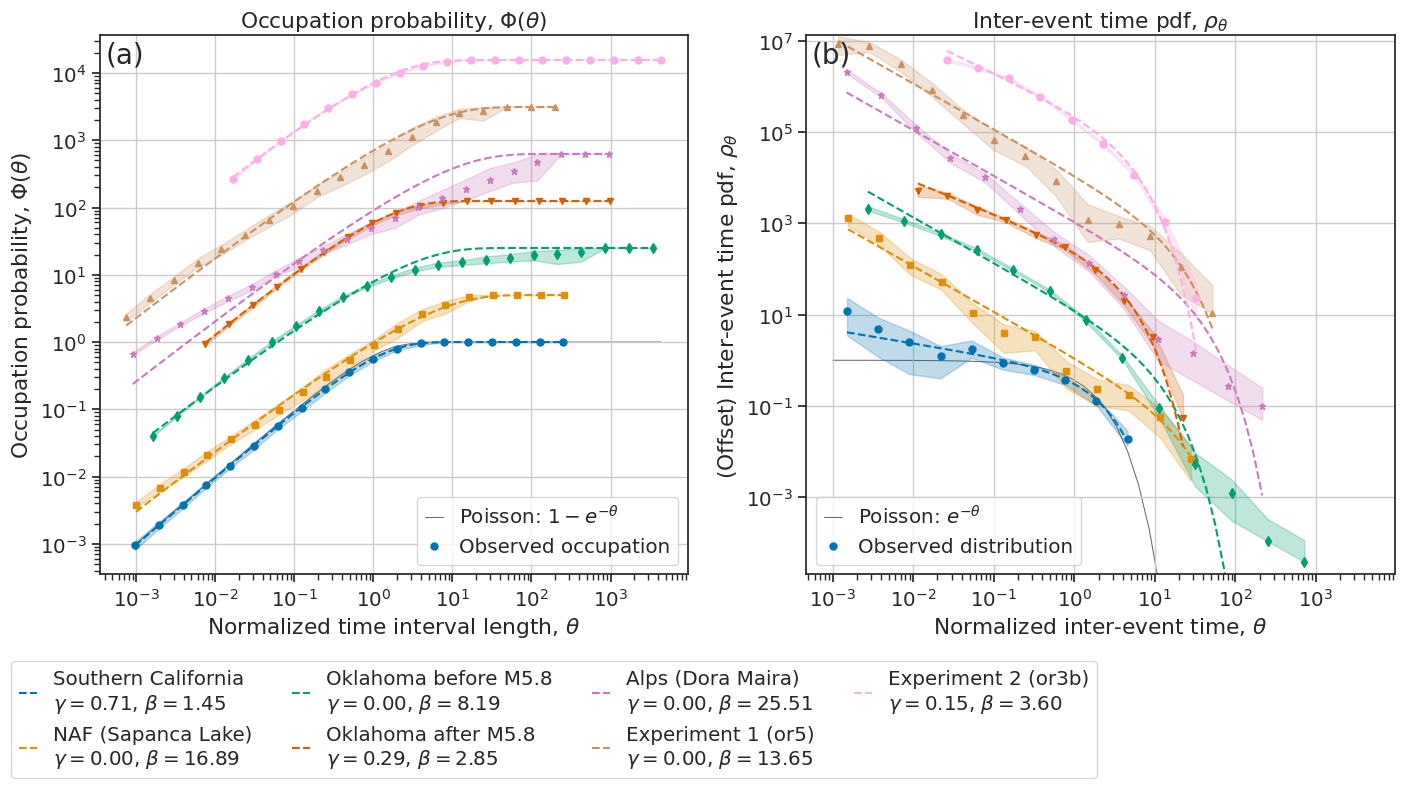

In [14]:
markers = ["o", "s", "d", "v", "*", "^"]
base_offset_occ = 5.0

fig, axes = plt.subplots(num="all_results_gamma", ncols=2, figsize=(14, 7))
plt.subplots_adjust(left=0.07, right=0.995)

time_max = max([occupation[ds]["tau"].max()] for ds in dataset_names)
wt_fit = np.logspace(np.log10(NORMALIZED_TAU_MIN), np.log10(time_max), 50)
tau_fit = np.logspace(np.log10(NORMALIZED_TAU_MIN), np.log10(time_max), 50)
axes[0].plot(
    tau_fit,
    1.0 - np.exp(-tau_fit),
    color="dimgrey",
    lw=0.75,
    zorder=0.0,
    label=r"Poisson: $1 - e^{-\theta}$",
)
axes[1].plot(
    wt_fit,
    np.exp(-wt_fit),
    color="dimgrey",
    lw=0.75,
    zorder=0.0,
    label=r"Poisson: $e^{-\theta}$",
)

fit_labels = []
fit_plots = []

for i, name in enumerate(plotting_order):
    wt_pdf = occupation[name]["wt_pdf"]
    wt_pdf_lower = occupation[name]["wt_pdf_lower"]
    wt_pdf_upper = occupation[name]["wt_pdf_upper"]
    wt_bins = occupation[name]["wt_bins"]
    tau = occupation[name]["tau"]
    Phi = occupation[name]["Phi"]
    Phi_lower = occupation[name]["Phi_lower"]
    Phi_upper = occupation[name]["Phi_upper"]

    valid_bins = wt_pdf > 0.0

    wt_fit = np.logspace(
        np.log10(wt_bins[valid_bins].min()), np.log10(wt_bins[valid_bins].max()), 50
    )
    tau_fit = np.logspace(np.log10(tau.min()), np.log10(tau.max()), 50)

    # correction factor for the gamma distribution, taking into account that
    # the empirical distribution is normalized over a finite range of waiting times
    truncated_C = eqtempclust.truncated_norm_gamma(
        occupation[name]["gamma"],
        occupation[name]["beta"],
        wt_bins.min(),
        wt_bins.max(),
    )
    theoretical_C = eqtempclust.theoretical_norm_gamma(
        occupation[name]["gamma"], occupation[name]["beta"]
    )
    ratio_C = theoretical_C / truncated_C

    label = "Observed distribution" if i == 0 else ""
    (wtplot,) = axes[1].plot(
        wt_bins[valid_bins],
        10.0**i * wt_pdf[valid_bins],
        ls="",
        markersize=5,
        marker=markers[i % len(markers)],
        label=label,
    )
    axes[1].fill_between(
        wt_bins[valid_bins],
        10.0**i * wt_pdf_lower[valid_bins],
        10.0**i * wt_pdf_upper[valid_bins],
        color=wtplot.get_color(),
        alpha=0.25,
    )

    label = "Observed occupation" if i == 0 else ""
    (occ,) = axes[0].plot(
        tau,
        base_offset_occ**i * Phi,
        ls="",
        markersize=5,
        marker=markers[i % len(markers)],
        label=label,
    )
    axes[0].fill_between(
        tau,
        base_offset_occ**i * Phi_lower,
        base_offset_occ**i * Phi_upper,
        color=occ.get_color(),
        alpha=0.25,
    )

    wt_gamma_model = eqtempclust.gamma_waiting_times(
        wt_fit, occupation[name]["gamma"], beta=occupation[name]["beta"], normalized=False
    )
    occupation_gamma_model = eqtempclust.occupation_probability_gamma_model(
        tau_fit, occupation[name]["gamma"], beta=occupation[name]["beta"]
    )

    label = f"{beautiful_names[name]}\n" r"$\gamma=$" f"{occupation[name]['gamma']:.2f}" r", $\beta=$"f"{occupation[name]['beta']:.2f}"
    (line,) = axes[0].plot(
        tau_fit,
        base_offset_occ**i * occupation_gamma_model,
        ls="--",
        color=occ.get_color(),
    )
    axes[1].plot(
        wt_fit, 10.0**i * wt_gamma_model / ratio_C, ls="--", color=occ.get_color()
    )
    fit_labels.append(label)
    fit_plots.append(line)

axes[0].set_title(r"Occupation probability, $\Phi(\theta)$")
axes[0].set_ylabel(r"Occupation probability, $\Phi(\theta)$")
axes[0].set_xlabel(r"Normalized time interval length, $\theta$")

axes[1].set_title(r"Inter-event time pdf, $\rho_{\theta}$")
axes[1].set_ylabel(r"(Offset) Inter-event time pdf, $\rho_{\theta}$")
axes[1].set_xlabel(r"Normalized inter-event time, $\theta$")

axes[1].legend(loc="lower left", handlelength=0.9)
axes[0].legend(loc="lower right", handlelength=0.9)
fig.legend(
    fit_plots,
    fit_labels,
    handlelength=0.9,
    ncol=4,
    bbox_to_anchor=(0.0, 0.0),
    loc="upper left",
)

axes[1].set_ylim(0.9 * wt_pdf[valid_bins].min(), axes[1].get_ylim()[1])

for i, ax in enumerate(axes):
    ax.grid()
    ax.loglog()
    ax.text(
        0.01,
        0.99,
        f"({string.ascii_lowercase[i]})",
        va="top",
        ha="left",
        fontsize=20,
        transform=ax.transAxes,
    )

In [15]:
# fig.savefig(
#     fig.get_label() + ".svg", bbox_inches="tight", format="svg"
# )

### part 3 (AIC)

Text(0.5, 1.0, 'AIC difference, $\\Delta$AIC=$AIC_{gamma} - AIC_{fractal}$')

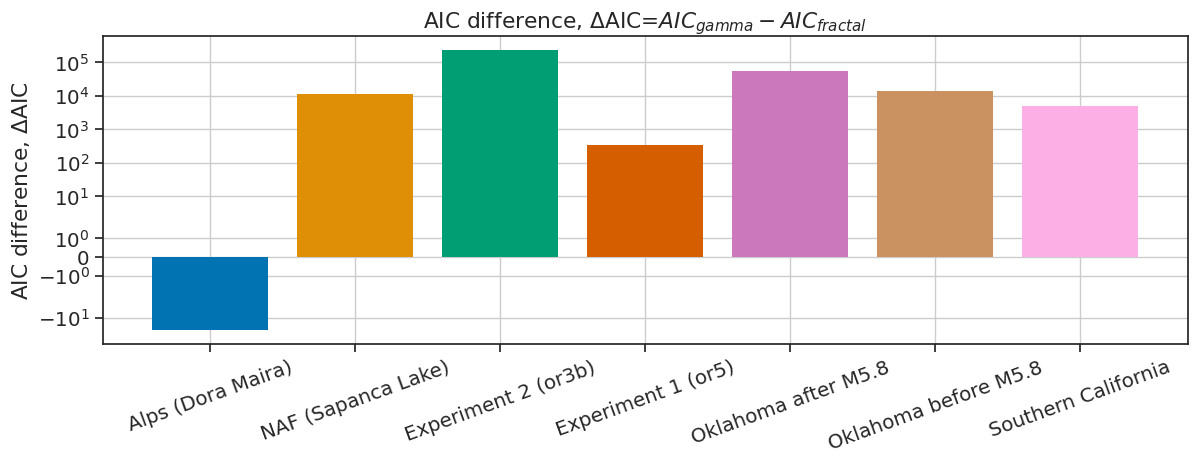

In [16]:

fig, ax = plt.subplots(num="aic_difference", figsize=(14, 4))
for i, name in enumerate(plotting_order):
    aic_gamma = occupation[name]["aic_gamma"]
    aic_fractal = occupation[name]["aic_fractal"]
    # probability that fractal model minimizes the information loss instead of the gamma model
    aic_diff = aic_gamma - aic_fractal
    ax.bar(i, aic_diff, ls="", label=beautiful_names[name])
ax.set_yscale("symlog")
ax.set_xticks(0.0 + np.arange(len(dataset_names)))
ax.set_xticklabels(
    [beautiful_names[name] for name in dataset_names],
    rotation=20,
    ha="center",
    va="top",
)
ax.grid()
ax.set_ylabel(r"AIC difference, $\Delta$AIC")
ax.set_title((r"AIC difference, $\Delta$AIC=$AIC_{gamma} - AIC_{fractal}$"))

In [17]:
# fig.savefig(
#     fig.get_label() + ".svg", bbox_inches="tight", format="svg"
# )

## Figure 3: Compare with forward model

/tmp/ipykernel_193033/3549949582.py:155: RuntimeWarning: invalid value encountered in divide
  syn_gamma_iet_i / syn_gamma_iet_i.mean(), bins=theta_, return_midbins=True
/home/eric/miniconda3/envs/py310/lib/python3.10/site-packages/eqtempclust.py:1102: RuntimeWarning: invalid value encountered in divide
  ie_pdf = ie_times_count / (bin_sizes * ie_times_count.sum())
/home/eric/miniconda3/envs/py310/lib/python3.10/site-packages/eqtempclust.py:1113: RuntimeWarning: invalid value encountered in divide
  ie_pdf_b[i, :] = ie_times_count_b / (bin_sizes * ie_times_count_b.sum())


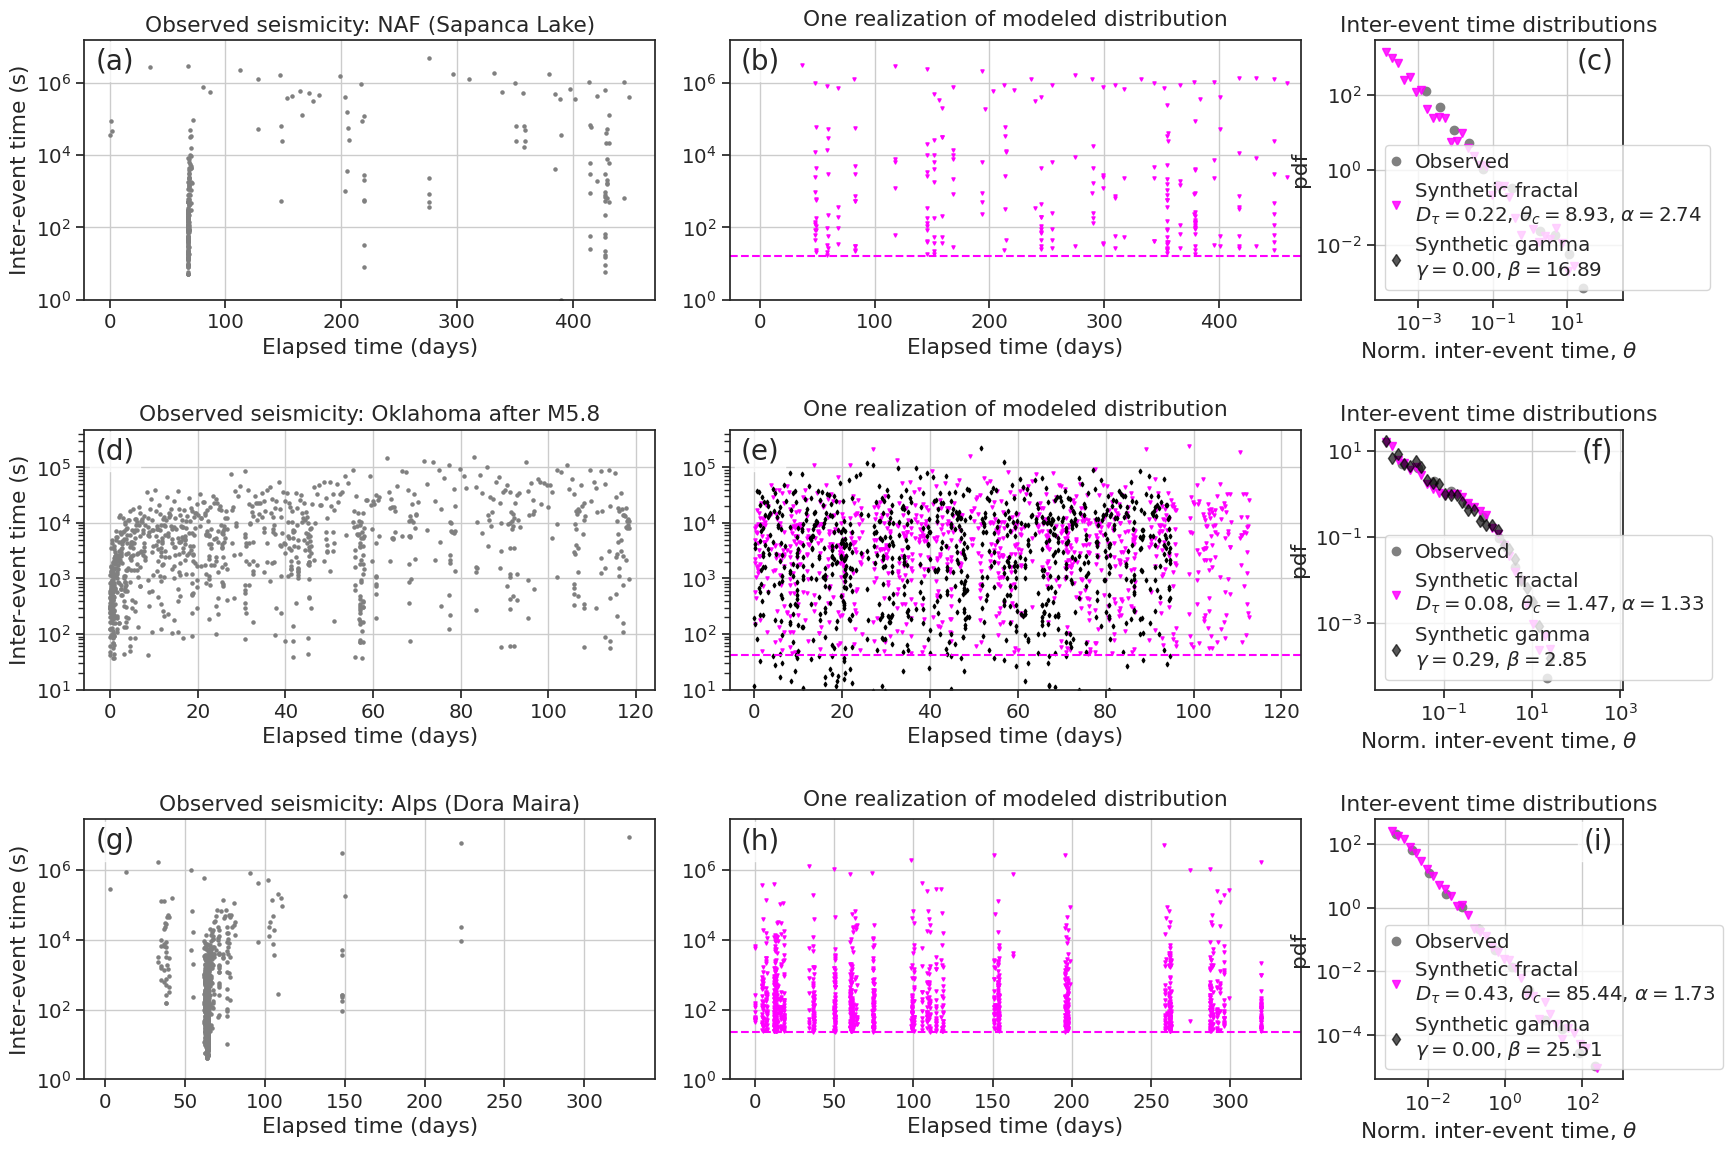

In [18]:
dataset_names = [
    "naf",
    "pawnee_after",
    "dora_maira",
]
COLOR_OBSERVED = "grey"
COLOR_GAMMA = "black"
COLOR_FRACTAL = "magenta"

ALPHA_GAMMA = 0.66
ALPHA_FRACTAL = 0.85
GAMMA_MIN = 0.
num_catalogs = len(dataset_names)

fig = plt.figure("compare_with_forward_model_v3", figsize=(18, 4.5 * num_catalogs))
gs = fig.add_gridspec(ncols=5, nrows=num_catalogs, wspace=0.3, hspace=0.5)

axes_iet_data = []
axes_iet_syn = []
axes_pdf = []

for i, catname in enumerate(dataset_names):
    # -------------------------------------------------
    interevent_times = np.hstack(
        (np.nan, event_timings[catname][1:] - event_timings[catname][:-1])
    )
    event_timings_days = event_timings[catname] / 86400.0
    event_timings_days -= event_timings_days[0]
    ax_iet_data = fig.add_subplot(gs[i, :2])
    ax_iet_data.scatter(
        event_timings_days,
        interevent_times,
        s=5,
        color=COLOR_OBSERVED,
        label="Observed",
        rasterized=True,
    )
    ax_iet_data.set_title(f"Observed seismicity: {beautiful_names[catname]}")
    axes_iet_data.append(ax_iet_data)
    # -------------------------------------------------
    ax_iet_syn = fig.add_subplot(gs[i, 2:4], sharey=ax_iet_data)
    D_tau_i = occupation[catname]["D_tau"]
    alpha_i = occupation[catname]["alpha"]
    theta_c_i = occupation[catname]["tau_c"]

    normalized_theta_min = eqtempclust.tau_min_fractal(
        1.0 - D_tau_i, theta_c_i, alpha_i
    )
    normalized_theta_max = occupation[catname]["wt_bins"].max()

    theta_ = np.logspace(
        np.log10(normalized_theta_min), np.log10(normalized_theta_max), 40
    )
    cdf_fractal_i = eqtempclust.cdf_fractal(theta_, 1.0 - D_tau_i, theta_c_i, alpha_i)
    inverse_cdf_fractal_i = interp1d(cdf_fractal_i, theta_)

    syn_fractal_iet_i = (
        inverse_cdf_fractal_i(
            np.random.uniform(
                low=cdf_fractal_i.min(),
                high=cdf_fractal_i.max(),
                size=len(event_timings_days),
            )
        )
        * occupation[catname]["wt_mean"]
    )

    syn_fractal_timings_i = np.cumsum(syn_fractal_iet_i)
    label_fractal = (
        f"Synthetic fractal\n"
        r"$D_\tau=$"
        f"{D_tau_i:.2f}, "
        r"$\theta_c=$"
        f"{theta_c_i:.2f}, "
        r"$\alpha=$"
        f"{alpha_i:.2f}"
    )
    ax_iet_syn.scatter(
        syn_fractal_timings_i / 86400.0,
        syn_fractal_iet_i,
        s=5,
        marker="v",
        label=label_fractal,
        color=COLOR_FRACTAL,
        rasterized=True,
    )
    ax_iet_syn.axhline(
        eqtempclust.tau_min_fractal(1.0 - D_tau_i, theta_c_i, alpha_i)
        * occupation[catname]["wt_mean"],
        color=COLOR_FRACTAL,
        ls="--",
    )

    gamma_i = occupation[catname]["gamma"]
    beta_i = occupation[catname]["beta"]

    cdf_gamma_i_min = eqtempclust.cdf_gamma(theta_.min(), gamma_i, beta_i)


    syn_gamma_iet_i = (
        eqtempclust.inverse_cdf_gamma(
            np.random.random(size=len(event_timings_days)),
            max(GAMMA_MIN, gamma_i),
            beta_i,

        )
        * occupation[catname]["wt_mean"]
    )

    syn_gamma_timings_i = np.cumsum(syn_gamma_iet_i)
    label_gamma = (
        f"Synthetic gamma\n" r"$\gamma=$" f"{gamma_i:.2f}, " r"$\beta=$" f"{beta_i:.2f}"
    )
    if gamma_i > GAMMA_MIN:
        ax_iet_syn.scatter(
            syn_gamma_timings_i / 86400.0,
            syn_gamma_iet_i,
            s=5,
            marker="d",
            label=label_gamma,
            color=COLOR_GAMMA, alpha=1,
            rasterized=True,
        )

    ax_iet_syn.set_title(
        rf"One realization of modeled distribution",
        pad=10,
    )
    # ax_iet_i.set_ylim(theta_.min() * occupation[catname]["wt_mean"], theta_.max() * occupation[catname]["wt_mean"])
    ylim_min = 10.**np.floor(np.log10(np.percentile(interevent_times[~np.isnan(interevent_times)], 1)))
    ylim_max = 10.**(np.log10(np.nanmax(interevent_times)) + 0.5)
    # ax_iet_syn.set_ylim(ylim_min, ylim_max)
    ax_iet_data.set_ylim(ylim_min, ylim_max)
    axes_iet_syn.append(ax_iet_syn)
    # -------------------------------------------------
    ax_pdf_i = fig.add_subplot(gs[i, 4])
    ax_pdf_i.plot(
        occupation[catname]["wt_bins"],
        occupation[catname]["wt_pdf"],
        ls="",
        marker="o",
        color=COLOR_OBSERVED,
        label="Observed",
    )
    axes_pdf.append(ax_pdf_i)
    # -------------------------------------------------
    wt_pdf, wt_pdf_lower, wt_pdf_upper, wt_log_bins = eqtempclust.interevent_pdf(
        syn_fractal_iet_i / syn_fractal_iet_i.mean(), bins=theta_, return_midbins=True
    )
    ax_pdf_i.plot(
        wt_log_bins, wt_pdf, ls="", marker="v", color=COLOR_FRACTAL, alpha=ALPHA_FRACTAL, label=label_fractal
    )
    # -------------------------------------------------
    wt_pdf, wt_pdf_lower, wt_pdf_upper, wt_log_bins = eqtempclust.interevent_pdf(
        syn_gamma_iet_i / syn_gamma_iet_i.mean(), bins=theta_, return_midbins=True
    )
    if gamma_i > GAMMA_MIN:
        ax_pdf_i.plot(wt_log_bins, wt_pdf, ls="", marker="d", color=COLOR_GAMMA, alpha=ALPHA_GAMMA, label=label_gamma)
    ax_pdf_i.set_title("Inter-event time distributions")

for i, (ax1, ax2, ax3) in enumerate(zip(axes_iet_data, axes_iet_syn, axes_pdf)):
    ax1.grid()
    ax1.set_yscale("log")
    ax1.set_xlabel("Elapsed time (days)")
    ax1.set_ylabel("Inter-event time (s)")
    # ax1.legend(loc="upper right", handlelength=0.3)

    ax2.grid()
    ax2.set_yscale("log")
    ax2.set_xlabel("Elapsed time (days)")
    # ax2.legend(loc="upper right", handlelength=0.3)
    ax2.set_xlim(ax2.get_xlim()[0], ax1.get_xlim()[1])

    ax3.grid()
    ax3.set_yscale("log")
    ax3.set_xscale("log")
    ax3.set_xlabel(r"Norm. inter-event time, $\theta$")
    ax3.set_ylabel("pdf")
    ax3.legend(loc="lower left", handlelength=0.3)

    ax1.text(
        0.02,
        0.97,
        f"({string.ascii_lowercase[3*i]})",
        va="top",
        fontsize=20,
        ha="left",
        bbox={"facecolor": "white", "alpha": 0.75},
        transform=ax1.transAxes,
    )
    ax2.text(
        0.02,
        0.97,
        f"({string.ascii_lowercase[3*i+1]})",
        va="top",
        fontsize=20,
        ha="left",
        bbox={"facecolor": "white", "alpha": 0.75},
        transform=ax2.transAxes,
    )
    ax3.text(
        0.96,
        0.97,
        f"({string.ascii_lowercase[3*i+2]})",
        va="top",
        fontsize=20,
        ha="right",
        bbox={"facecolor": "white", "alpha": 0.75},
        transform=ax3.transAxes,
    )

plt.subplots_adjust(right=0.98, wspace=0.5)

In [19]:
# fig.savefig(
#     fig.get_label() + ".svg", bbox_inches="tight", format="svg", dpi=250
# )